# Notebook DSC MCF ITB Tim Analisis Ngaco 
<br>
Notebook ini berisi pemodelan untuk prediksi kolesterol total dan analisis variabel yang berpengaruh terhadap kolesterol total

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score,recall_score, f1_score, roc_auc_score

## Data Understanding

Terlebih dahu, kami melakukan pemahaman tentang data yang meliputi: <br>
- Load data 
- Melihat data
- Statistika Deskriptif
- pengecekan missing data
- pengecekan duplicate data

In [22]:
df = pd.read_excel("A:/Lomba PT/DSC ITB/Data2/Data2.xlsx")
df.head()

,Responden,Jenis Kelamin,Usia,Tekanan darah (S),Tekanan darah (D),Tinggi badan (cm),Berat badan (kg),IMT (kg/m2),Lingkar perut (cm),Glukosa Puasa (mg/dL),Cholesterol Total (mg/dL),Trigliserida (mg/dL),Fat,Visceral Fat,Masa Kerja,Tempat lahir
0,1,M,19,126,88,172.5,49.5,16.53,66.0,84,187,99,26.4,6.0,0.971199,Purworejo
1,2,M,19,120,80,158.0,53.6,21.50,71.0,84,187,99,26.4,6.0,0.600000,Bogor
2,3,M,19,120,80,170.0,59.5,20.59,80.0,80,187,99,26.4,6.0,1.373939,bandung
3,4,F,19,100,70,149.0,45.1,20.31,62.0,81,187,99,30.5,3.5,1.000000,Jakarta
4,5,M,19,110,70,171.6,62.4,21.19,78.0,84,187,99,26.4,6.0,4.000000,Teluk Betung


In [23]:
df.shape

(1339, 16)

**Statistik Deskriptif**

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Responden,1339.0,670.000000,386.680316,1.00,335.500,670.0,1004.500,1339.00
Usia,1339.0,28.597461,4.767230,19.00,25.000,28.0,31.000,39.00
Tekanan darah (S),1339.0,113.147872,10.164592,80.00,110.000,110.0,120.000,170.00
Tekanan darah (D),1339.0,74.009709,7.718752,58.00,70.000,72.0,80.000,100.00
Tinggi badan (cm),1339.0,164.940851,7.386617,138.50,160.000,165.0,170.000,187.50
Berat badan (kg),1339.0,64.620503,12.799095,38.50,55.275,62.5,71.775,139.75
IMT (kg/m2),1339.0,23.693727,4.021585,14.85,20.855,23.2,26.000,44.10
Lingkar perut (cm),1339.0,80.441972,10.688215,54.00,72.000,80.0,87.000,128.00
Glukosa Puasa (mg/dL),1339.0,84.571322,11.522057,65.00,84.000,84.0,84.000,321.00
Cholesterol Total (mg/dL),1339.0,187.995519,21.104834,103.00,187.000,187.0,187.000,308.00


**Cek missing dan duplicate**

In [25]:
#Melihat kolom null pada dataset Train
df.info()
print("\nBanyak data duplikat: "+ str(df.duplicated().sum().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Responden                  1339 non-null   int64  
 1   Jenis Kelamin              1339 non-null   object 
 2   Usia                       1339 non-null   int64  
 3   Tekanan darah  (S)         1339 non-null   int64  
 4   Tekanan darah  (D)         1339 non-null   int64  
 5   Tinggi badan (cm)          1339 non-null   float64
 6   Berat badan (kg)           1339 non-null   float64
 7   IMT (kg/m2)                1339 non-null   float64
 8   Lingkar perut (cm)         1339 non-null   float64
 9   Glukosa Puasa (mg/dL)      1339 non-null   int64  
 10  Cholesterol Total (mg/dL)  1339 non-null   int64  
 11  Trigliserida (mg/dL)       1339 non-null   int64  
 12  Fat                        1339 non-null   float64
 13  Visceral Fat               1339 non-null   float

## Data Cleaning

**Mengubah nama variabel untuk memudahkan proses pembuatan model**

In [26]:
# Rename columns without parentheses
df = df.rename(columns={
    'Tekanan darah  (S)': 'TdS',
    'Tekanan darah  (D)': 'TdD',
    'Tinggi badan (cm)': 'Tinggi Badan',
    'Berat badan (kg)': 'Berat Badan',
    'IMT (kg/m2)': 'IMT',
    'Lingkar perut (cm)': 'Lingkar Perut',
    'Glukosa Puasa (mg/dL)': 'Glukosa Puasa',
    'Cholesterol Total (mg/dL)': 'Cholesterol Total',
    'Trigliserida (mg/dL)': 'Trigliserida',
    'Fat': 'Fat',
    'Visceral Fat': 'Visceral Fat',
    'Masa Kerja': 'Masa Kerja',
    'Tempat lahir': 'Tempat Lahir'
})

# Show the DataFrame to verify the changes
print(df.columns)

Index(['Responden', 'Jenis Kelamin', 'Usia', 'TdS', 'TdD', 'Tinggi Badan',
       'Berat Badan', 'IMT', 'Lingkar Perut', 'Glukosa Puasa',
       'Cholesterol Total', 'Trigliserida', 'Fat', 'Visceral Fat',
       'Masa Kerja', 'Tempat Lahir'],
      dtype='object')


### Deteksi dan Penanganan Outlier

In [27]:
df.columns

Index(['Responden', 'Jenis Kelamin', 'Usia', 'TdS', 'TdD', 'Tinggi Badan',
       'Berat Badan', 'IMT', 'Lingkar Perut', 'Glukosa Puasa',
       'Cholesterol Total', 'Trigliserida', 'Fat', 'Visceral Fat',
       'Masa Kerja', 'Tempat Lahir'],
      dtype='object')

**Grafik distribusi data 'Cholesterol Total', 'Trigliserida', 'Fat', 'Visceral Fat' dan 'Glukosa Puasa'**

In [28]:
# Misalkan df adalah dataframe yang telah diinisialisasi sebelumnya

col = list(df.columns)
categoric = []
numeric = []

for i in col:
    if df[i].dtype == 'O':  # Memeriksa apakah tipe data adalah string
        categoric.append(i)
    else:
        numeric.append(i)

print('Categorical Features:', *categoric)
print('Numerical Features:', *numeric)

Categorical Features: Jenis Kelamin Tempat Lahir
Numerical Features: Responden Usia TdS TdD Tinggi Badan Berat Badan IMT Lingkar Perut Glukosa Puasa Cholesterol Total Trigliserida Fat Visceral Fat Masa Kerja


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_41784\89331240.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 3, i + 1)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_41784\89331240.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 3, i + 1)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_41784\89331240.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 3, i + 1)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_41784\89331240.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explic

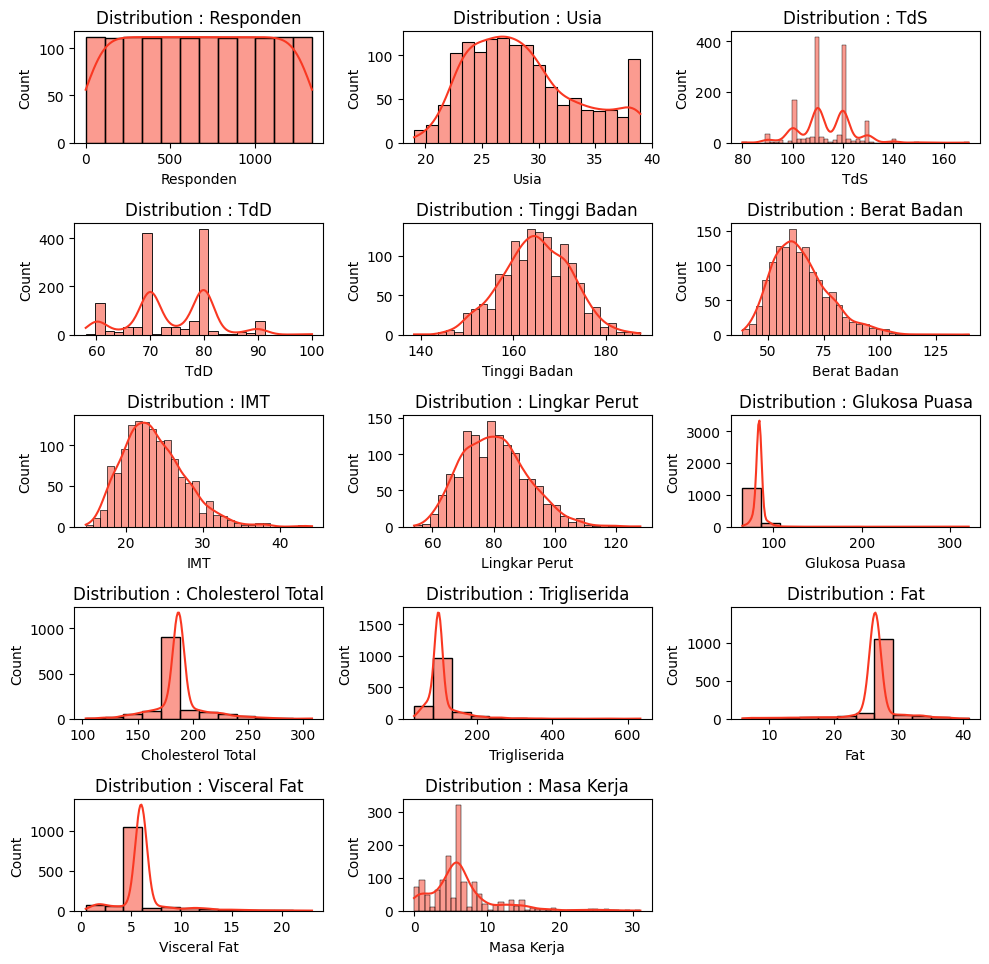

In [29]:
# Plot Numerik data

colors = ['#F93822','#FDD20E']
# Membuat subplot untuk menampilkan distribusi kolom numerik
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (10,9.75))
for i in range(len(numeric)):
    plt.subplot(5, 3, i + 1)
    sns.histplot(df[numeric[i]], kde=True, color=colors[0])
    title = 'Distribution : ' + numeric[i]
    plt.title(title)

plt.tight_layout()
plt.show()

Dari grafik diatas dapat dilihat bahwa beberapa data memiliki data yang frekuensinya jauh melebihi yang lain

**Deteksi Outlier untuk data numerik**

Untuk mendeteksi outlier, digunakan LocalOutlierFactor. <br>
Hal ini dikarenakan outlier yang ada di data ini berkaitan dengan kepadatan alias perbedaan frekuensi data yang ekstrim di beberapa variabel

In [30]:
# Membuat model LOF
lof_model = LocalOutlierFactor(n_neighbors=20)  # Sesuaikan jumlah tetangga (n_neighbors) sesuai kebutuhan

for i in df:
    # Menghitung skor LOF
    lof_scores = lof_model.fit_predict(df[numeric])

    # Mengambil indeks outlier (skor LOF < 0)
    outlier_indices = np.where(lof_scores == -1)[0]

# Menampilkan indeks outlier
print("Indeks outlier: ", outlier_indices)





Indeks outlier:  [   5   48   52   54  108  127  134  146  147  153  166  169  173  177
  189  194  199  248  255  257  279  284  302  310  311  317  330  335
  361  364  385  422  423  445  453  459  471  492  498  503  506  510
  511  513  522  549  552  560  571  572  575  602  606  621  641  645
  649  651  655  677  684  704  710  719  732  736  738  741  762  769
  777  796  798  804  813  823  825  828  830  832  858  860  869  871
  901  906  908  909  918 1049 1154 1162 1194 1217 1219 1325]


Terlihat dari hasil LOF diatas terdapat outlier 


**Pengananan Outlier untuk data numerik**

Akan dihapus baris dengan indeks outlier

In [31]:
# Menghapus baris dengan indeks outlier
df = df.drop(outlier_indices)

df


,Responden,Jenis Kelamin,Usia,TdS,TdD,Tinggi Badan,Berat Badan,IMT,Lingkar Perut,Glukosa Puasa,Cholesterol Total,Trigliserida,Fat,Visceral Fat,Masa Kerja,Tempat Lahir
0,1,M,19,126,88,172.5,49.50,16.53,66.0,84,187,99,26.4,6.0,0.971199,Purworejo
1,2,M,19,120,80,158.0,53.60,21.50,71.0,84,187,99,26.4,6.0,0.600000,Bogor
2,3,M,19,120,80,170.0,59.50,20.59,80.0,80,187,99,26.4,6.0,1.373939,bandung
3,4,F,19,100,70,149.0,45.10,20.31,62.0,81,187,99,30.5,3.5,1.000000,Jakarta
4,5,M,19,110,70,171.6,62.40,21.19,78.0,84,187,99,26.4,6.0,4.000000,Teluk Betung
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,1335,M,39,110,70,162.5,67.60,25.60,87.0,84,169,72,23.8,11.0,6.000000,Bogor
1335,1336,F,39,120,70,150.0,60.50,26.90,77.0,84,199,105,38.1,9.0,6.154761,Bogor
1336,1337,F,39,120,80,151.0,59.75,26.20,78.0,84,177,78,35.3,8.0,26.000000,Bogor
1337,1338,M,39,110,70,166.2,57.00,20.63,69.0,84,244,98,17.1,5.0,4.297226,Bogor


**Pengecekan observasi pada usia dan masa kerja** <br>

Anomali yang berkaitan dengan masa kerja dan usia akan dilihat dari usia seseorang mulai bekerja di perusahaan tersebut. <br><br>

Berdasarkan Undang-Undang no.13 tahun 2003 pasal 69, usia minimal bekerja ialah 13 sampai 15 tahun. <br>
Dengan UU ini sebagai patokan batas minimal usia bekerja, akan di cek apakah usia disaat seseorang mulai bekerja memenuhi Undang-Undang tersebut yakni 13 tahun.

In [32]:
df['Masa Kerja'] = round(df['Masa Kerja'])
df['Usia'] = round(df['Usia'])

In [33]:
# Melakukan filtering berdasarkan aturan jika Usia - Masa Kerja < 13
df = df[(df['Usia'] - df['Masa Kerja']) >= 13]

# Menampilkan dataframe setelah filtering
print("\nDataframe setelah filtering:")
df.shape


Dataframe setelah filtering:


(1213, 16)

**Mengubah beberapa data numerik menjadi data kategorik** <br>
Data yang akan diubah menjadi data kategorik adalah:
- Jenis Kelamin
- Usia
- IMT
- Cholesterol Total

In [34]:
# Change "Jenis Kelamin"
df['Jenis Kelamin'] = df['Jenis Kelamin'].map({'F': 0, 'M': 1})

# Mapping "Usia"
def map_usia(usia):
    if 19 <= usia <= 26:
        return 0
    elif 27 <= usia <= 32:
        return 1
    elif 33 <= usia <= 39:
        return 2

df['Usia'] = df['Usia'].apply(map_usia)

# Maps "IMT (kg/m2)"
def map_imt(imt):
    if imt < 18.5:
        return 0
    elif 18.5 <= imt < 25:
        return 1
    elif 25 <= imt < 30:
        return 2
    else:
        return 3

# Assuming 'IMT' column exists
df['IMT'] = df['IMT'].apply(map_imt)

df['Cholesterol Total'] = df['Cholesterol Total'].apply(lambda x: 1 if x >= 200 else 0)

#Drop data Trigliserida < 50
#Map Trigliserida menjadi 
# 0: 50-150. 
# 1: Kadar trigliserida 150–199 mg/dL. 
# 2: Kadar trigliserida 200–499 mg/dL. 
# 3: Kadar trigliserida lebih dari 500 mg/dL

df = pd.DataFrame(df)

df.head(1)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_41784\2310361324.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Jenis Kelamin'] = df['Jenis Kelamin'].map({'F': 0, 'M': 1})
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_41784\2310361324.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Usia'] = df['Usia'].apply(map_usia)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_41784\2310361324.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,Responden,Jenis Kelamin,Usia,TdS,TdD,Tinggi Badan,Berat Badan,IMT,Lingkar Perut,Glukosa Puasa,Cholesterol Total,Trigliserida,Fat,Visceral Fat,Masa Kerja,Tempat Lahir
0,1,1,0,126,88,172.5,49.5,0,66.0,84,0,99,26.4,6.0,1.0,Purworejo


## Exploratory Data Analysis

Mengembalikan data tempat lahir yang disimpan di variabel temp_lah untuk keperluan beberapa grafik exploratory data analysis

**Distribusi rata-rata variabel terhadap CT**

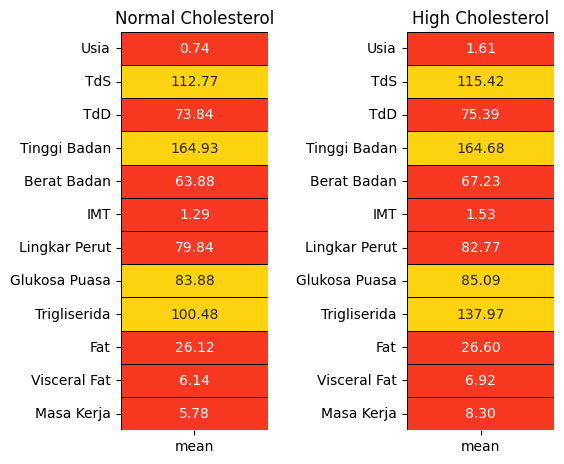

In [35]:
no = df[['Usia','TdS','TdD','Tinggi Badan','Berat Badan','IMT','Lingkar Perut','Glukosa Puasa','Trigliserida','Fat','Visceral Fat','Masa Kerja']][df['Cholesterol Total'] == 0].describe().T
yes = df[['Usia','TdS','TdD','Tinggi Badan','Berat Badan','IMT','Lingkar Perut','Glukosa Puasa','Trigliserida','Fat','Visceral Fat','Masa Kerja']][df['Cholesterol Total'] == 1].describe().T
colors = ['#F93822','#FDD20E']

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (6,5))
plt.subplot(1,2,1)
sns.heatmap(no[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f',)
plt.title('Normal Cholesterol');

plt.subplot(1,2,2)
sns.heatmap(yes[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('High Cholesterol');

fig.tight_layout(pad=2)

**Countplot kolesterol total untuk setiap range usia**

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_41784\2534089277.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['19-26 tahun', '27-31 tahun','32-39 tahun'])


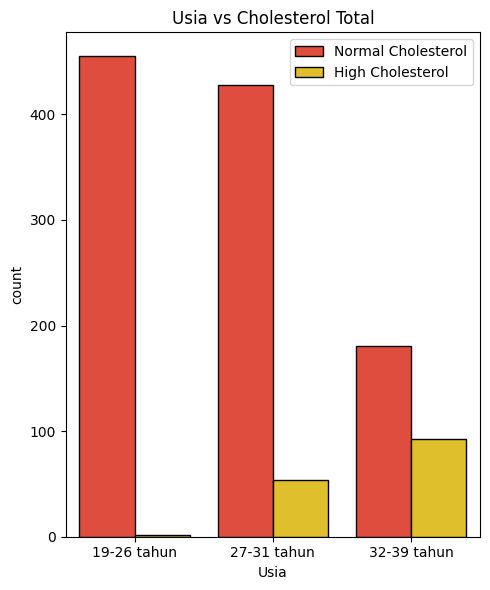

In [36]:
fig, ax = plt.subplots(figsize=(5, 6))

sns.countplot(x=df['Usia'], data=df, hue="Cholesterol Total", palette=colors, edgecolor='black')

title = 'Usia'+ ' vs Cholesterol Total'
plt.legend(['Normal Cholesterol', 'High Cholesterol'])
plt.title(title)
ax.set_xticklabels(['19-26 tahun', '27-31 tahun','32-39 tahun'])

plt.tight_layout()
plt.show()

**Countplot kolesterol total untuk jenis usia**

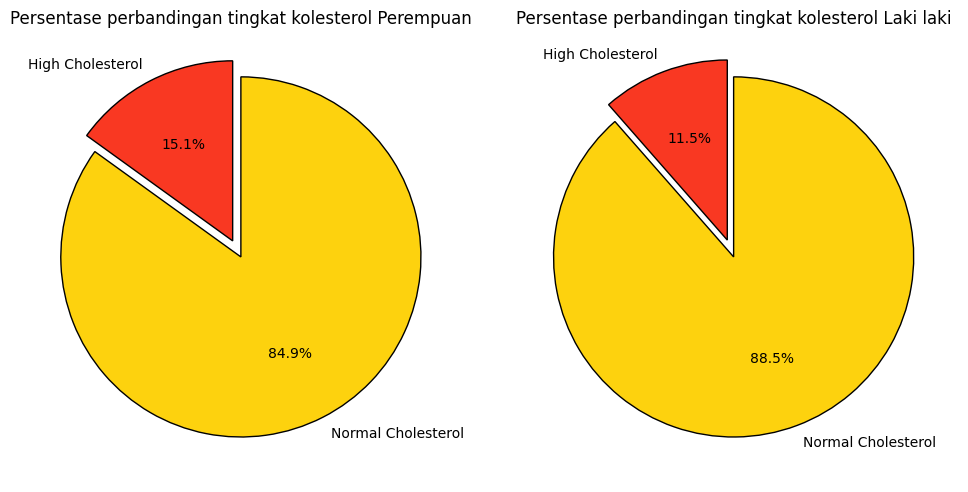

Jenis Kelamin  Cholesterol Total
0              0                    237
               1                     42
Name: count, dtype: int64
Jenis Kelamin  Cholesterol Total
1              0                    827
               1                    107
Name: count, dtype: int64


In [37]:
pie_perempuan = df[['Jenis Kelamin','Cholesterol Total']][df['Jenis Kelamin'] == 0]
pie_laki = df[['Jenis Kelamin','Cholesterol Total']][df['Jenis Kelamin'] == 1]

lper = list(pie_perempuan['Cholesterol Total'].value_counts())
llak = list(pie_laki['Cholesterol Total'].value_counts())
circle_perempuan = [lper[1] / sum(lper) * 100,lper[0] / sum(lper) * 100]
circle_laki = [llak[1] / sum(llak) * 100,llak[0] / sum(llak) * 100]

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (10,5))
plt.subplot(1,2,1)
plt.pie(circle_perempuan,labels = ['High Cholesterol','Normal Cholesterol'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Persentase perbandingan tingkat kolesterol Perempuan');

plt.subplot(1,2,2)
plt.pie(circle_laki,labels = ['High Cholesterol','Normal Cholesterol'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Persentase perbandingan tingkat kolesterol Laki laki');

plt.tight_layout()
plt.show()

print(pie_perempuan.value_counts())
print(pie_laki.value_counts())

**10 Tempat dengan penderita Cholesterol Total tinggi tertinggi**

In [38]:
# Menghitung jumlah 'Cholesterol Total' tinggi berdasarkan 'Tempat lahir'
cholesterol_counts_by_location = df[df['Cholesterol Total'] == 1]['Tempat Lahir'].value_counts().head(10)

# Menampilkan 10 'Tempat lahir' dengan jumlah 'Cholesterol Total' tinggi tertinggi
print("10 Tempat lahir dengan penderita Cholesterol Total tinggi tertinggi:")
print(cholesterol_counts_by_location)

10 Tempat lahir dengan penderita Cholesterol Total tinggi tertinggi:
Tempat Lahir
Jakarta       44
Bogor         36
Bandung       14
Semarang       8
Bekasi         5
Surabaya       4
Sukabumi       3
Sumedang       2
Yogyakarta     2
Palembang      2
Name: count, dtype: int64


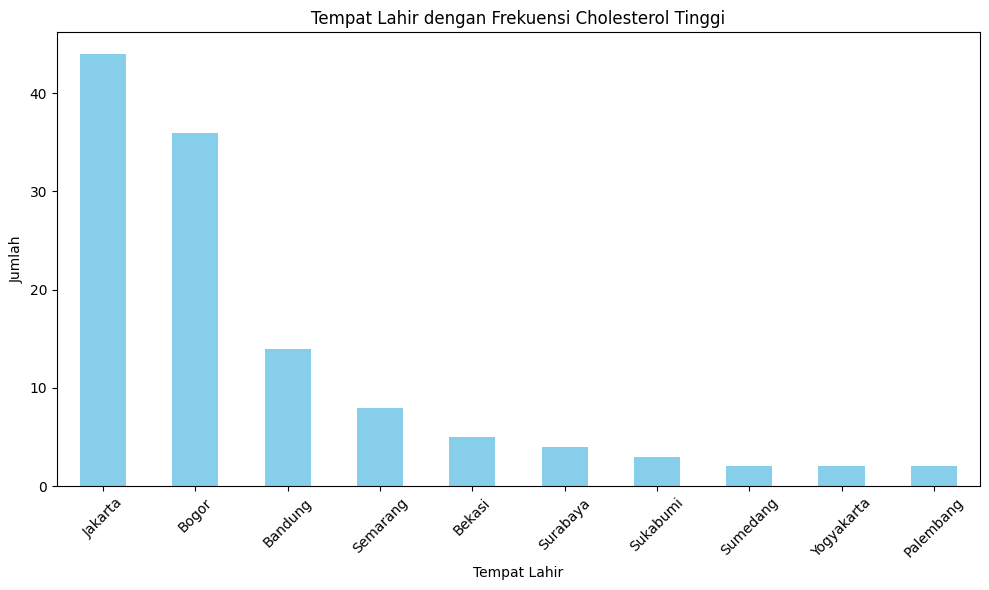

In [39]:
# Membuat plot
plt.figure(figsize=(10, 6))
cholesterol_counts_by_location.plot(kind='bar', color='skyblue')
plt.xlabel('Tempat Lahir')
plt.ylabel('Jumlah')
plt.title('Tempat Lahir dengan Frekuensi Cholesterol Tinggi')
plt.xticks(rotation=45)  # Untuk memutar label sumbu x agar lebih mudah dibaca
plt.tight_layout()
plt.show()

## Feature Engineering

In [40]:
encoder = OneHotEncoder()
onehot=['Usia', 'Jenis Kelamin', 'IMT']
# Melakukan one-hot encoding
df =  pd.get_dummies(df, columns=onehot, prefix=onehot)

#Melihat fitur yang tercipta
df.head(1)

,Responden,TdS,TdD,Tinggi Badan,Berat Badan,Lingkar Perut,Glukosa Puasa,Cholesterol Total,Trigliserida,Fat,...,Tempat Lahir,Usia_0,Usia_1,Usia_2,Jenis Kelamin_0,Jenis Kelamin_1,IMT_0,IMT_1,IMT_2,IMT_3
0,1,126,88,172.5,49.5,66.0,84,0,99,26.4,...,Purworejo,True,False,False,False,True,True,False,False,False


### Correlation Heatmap

In [41]:
# Menghapus kolom dari DataFrame
df.drop(columns=['Responden','Tempat Lahir'], inplace=True)

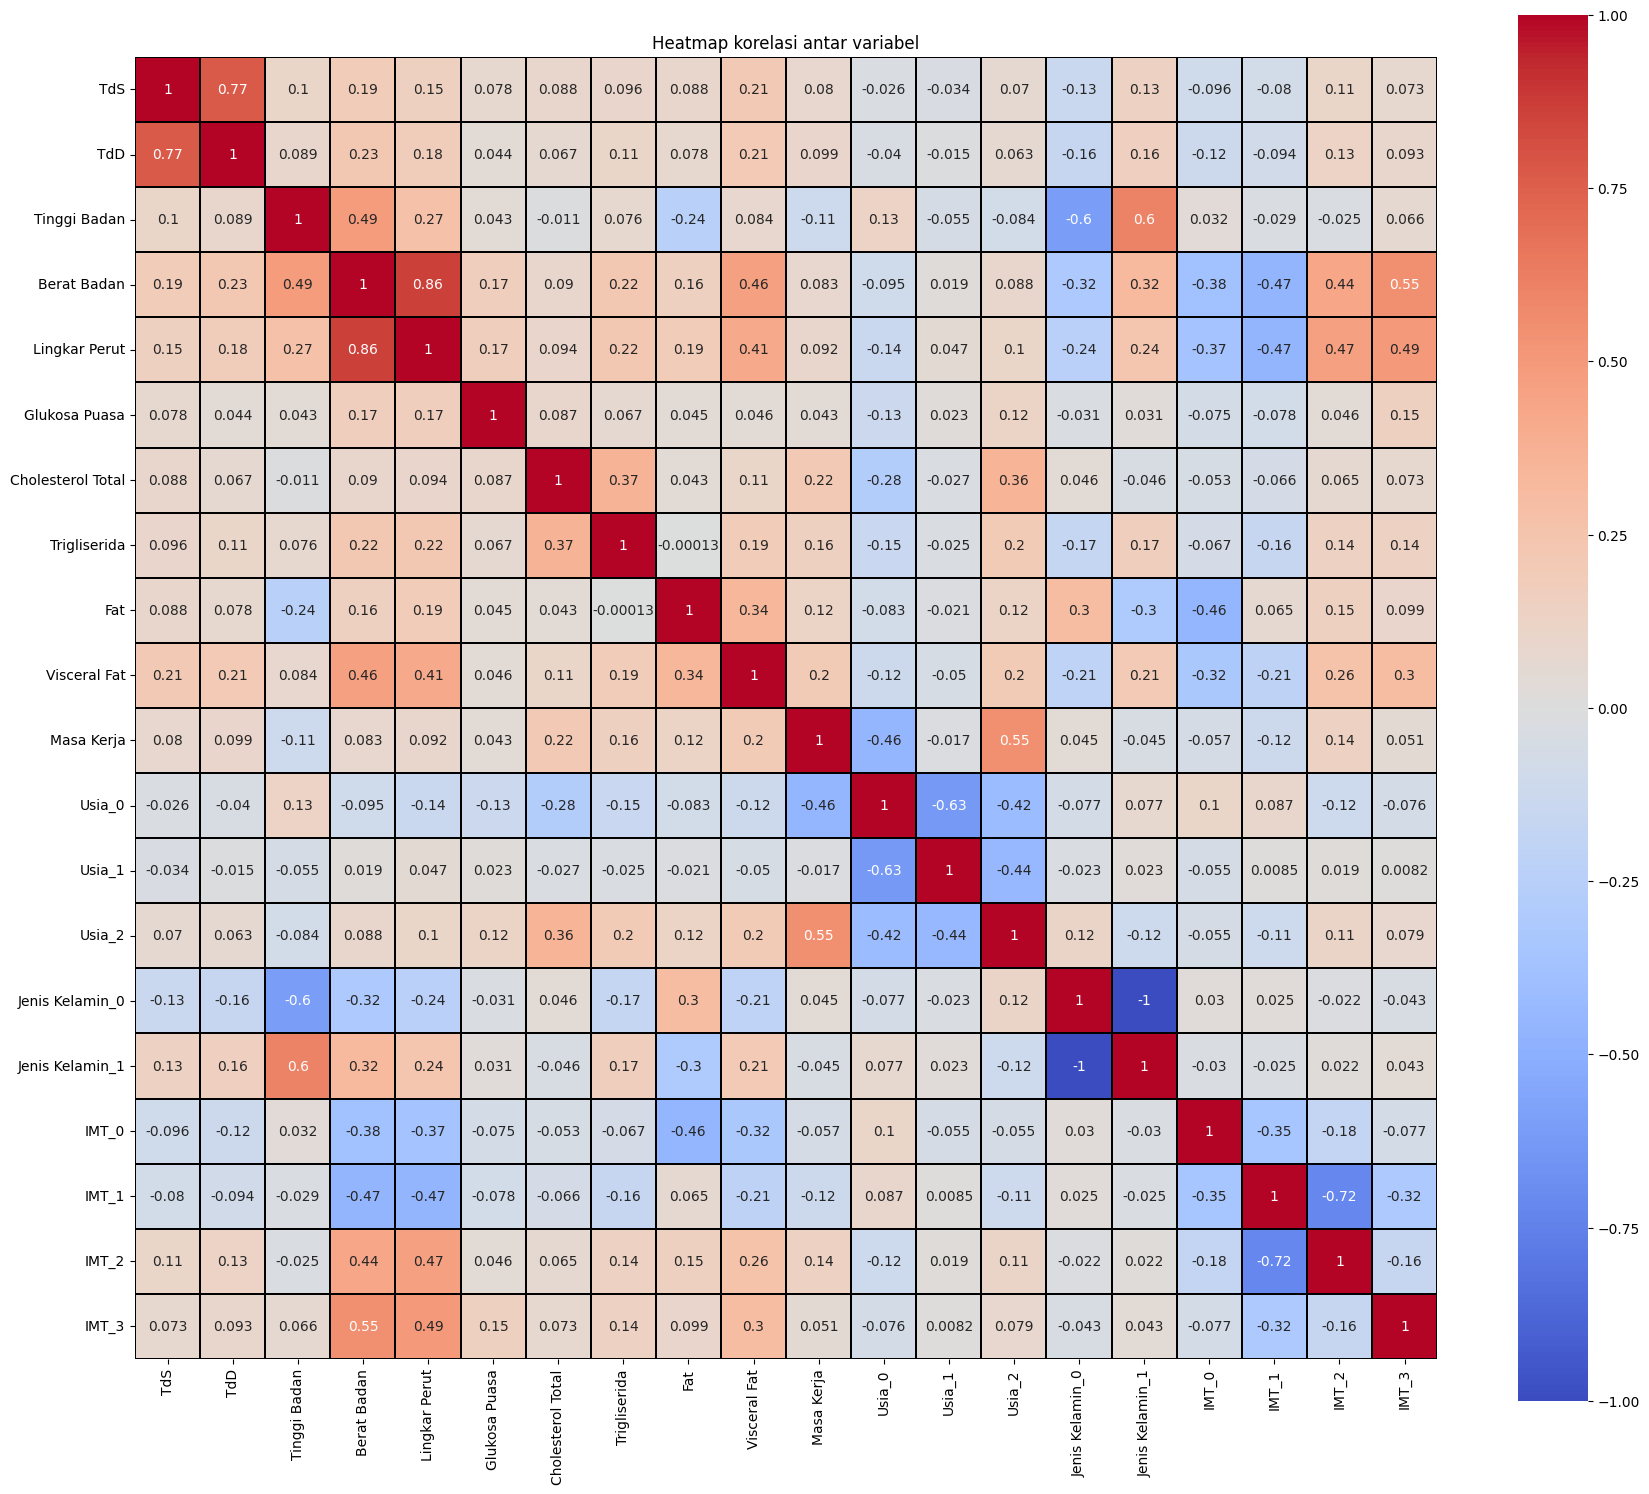

In [42]:
correlations = df.corr()
plt.figure(figsize=(21,18))
sns.heatmap(correlations,linewidths=0.25, cmap="coolwarm", annot=True, cbar=True, square=True, linecolor='black')
plt.title('Heatmap korelasi antar variabel')
plt.show()

Dikarenakan nilai korelasi tertinggi semua variabel terhadap kolesterol total kurang dari 0.4. <br>
Maka variabel yang berpengaruh yang akan diambil adalah yang nilain korelasina dibawah 0.1, yakni:
- Trigliserida
- Visceral Fat
- Masa Kerja
- Usia_2

## Modelling dan Tuning

### Split data train dan test

In [43]:
X =df.drop(columns='Cholesterol Total',axis=1)
y = df['Cholesterol Total']

Dikarenakan masih adanya imbalance pada beberapa fitur dan target maka akan digunakan SMOTE

In [44]:
# Resampling dengan SMOTE
X_resampled, y_resampled = SMOTE(k_neighbors=5, random_state=42).fit_resample(X, y)

### XGBoost

In [47]:
X_train_xg, X_test_xg, y_train_xg, y_test_xg = train_test_split(X_resampled, y_resampled, test_size=0.4,random_state=42)

In [48]:
mod = XGBClassifier()

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'gamma': [0, 0.25, 0.4, 0.5, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8,0.9,1.0],
}

**Tuning dengan RandomizesSearchCV**

In [49]:
random_search = RandomizedSearchCV(mod, param_distributions=param_grid, n_iter=35,
                                   scoring="roc_auc", cv=5, verbose=0, random_state=99)

In [50]:
random_search.fit(X_train_xg, y_train_xg)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=35,
                   param_distributions={'colsample_bytree': [0.4, 0.5, 0.6, 0.7,
                                                             0.8, 0.9, 1.0],
                                        'gamma': [0, 0.25, 0.4, 0.5, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   random_state=99, scoring='roc_auc')

In [51]:
p = random_search.best_params_
for k, v in p.items():
    print(f"{k}={v},")

subsample=0.8,
min_child_weight=1,
max_depth=10,
learning_rate=0.1,
gamma=0.25,
colsample_bytree=0.8,


In [52]:
model = XGBClassifier(objective="binary:logistic",
                        subsample=0.8,
                        min_child_weight=1,
                        max_depth=10,
                        learning_rate=0.1,
                        gamma=0.25,
                        colsample_bytree=0.8,
)   

In [53]:
model.fit(X_train_xg, y_train_xg)
y_pred_xg = model.predict(X_test_xg)

In [54]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test_xg, y_pred_xg)
precision = precision_score(y_test_xg, y_pred_xg)
recall = recall_score(y_test_xg, y_pred_xg)
f1 = f1_score(y_test_xg, y_pred_xg)
roc_auc = roc_auc_score(y_test_xg, y_pred_xg)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_xg, y_pred_xg))

Accuracy: 0.9413145539906104
Precision: 0.9144736842105263
Recall: 0.9742990654205608
F1 Score: 0.9434389140271493
ROC AUC Score: 0.9411589666725445

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       424
           1       0.91      0.97      0.94       428

    accuracy                           0.94       852
   macro avg       0.94      0.94      0.94       852
weighted avg       0.94      0.94      0.94       852

